In [1]:
import os
import pandas as pd
import luto.settings as settings
import rasterio
import numpy as np
from affine import Affine
import xarray as xr
from scipy.interpolate import interp1d
from plotnine import (
    ggplot, aes, geom_line, geom_point, geom_hline, facet_wrap,
    theme_bw, labs, theme, element_text, scale_color_brewer, scale_y_continuous, scale_color_manual
)

def update_geo_meta():
    """
    Update the geographic metadata based on the current settings.

    Note: When this function is called, the RESFACTOR is assumend to be > 1,
    because there is no need to update the metadata if the RESFACTOR is 1.

    Returns
        dict: The updated geographic metadata.
    """
    meta = GEO_META_FULLRES.copy()
    height, width =  LUMAP_2D_RESFACTORED.shape
    trans = list(GEO_META_FULLRES['transform'])
    trans[0] = trans[0] * settings.RESFACTOR    # Adjust the X resolution
    trans[4] = trans[4] * settings.RESFACTOR    # Adjust the Y resolution
    trans = Affine(*trans)
    meta.update(width=width, height=height, compress='lzw', driver='GTiff', transform=trans, nodata=NODATA, dtype='float32')
    return meta


C:\Users\s222552331\AppData\Local\Temp\35\ipykernel_231080\4141695906.py:77: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


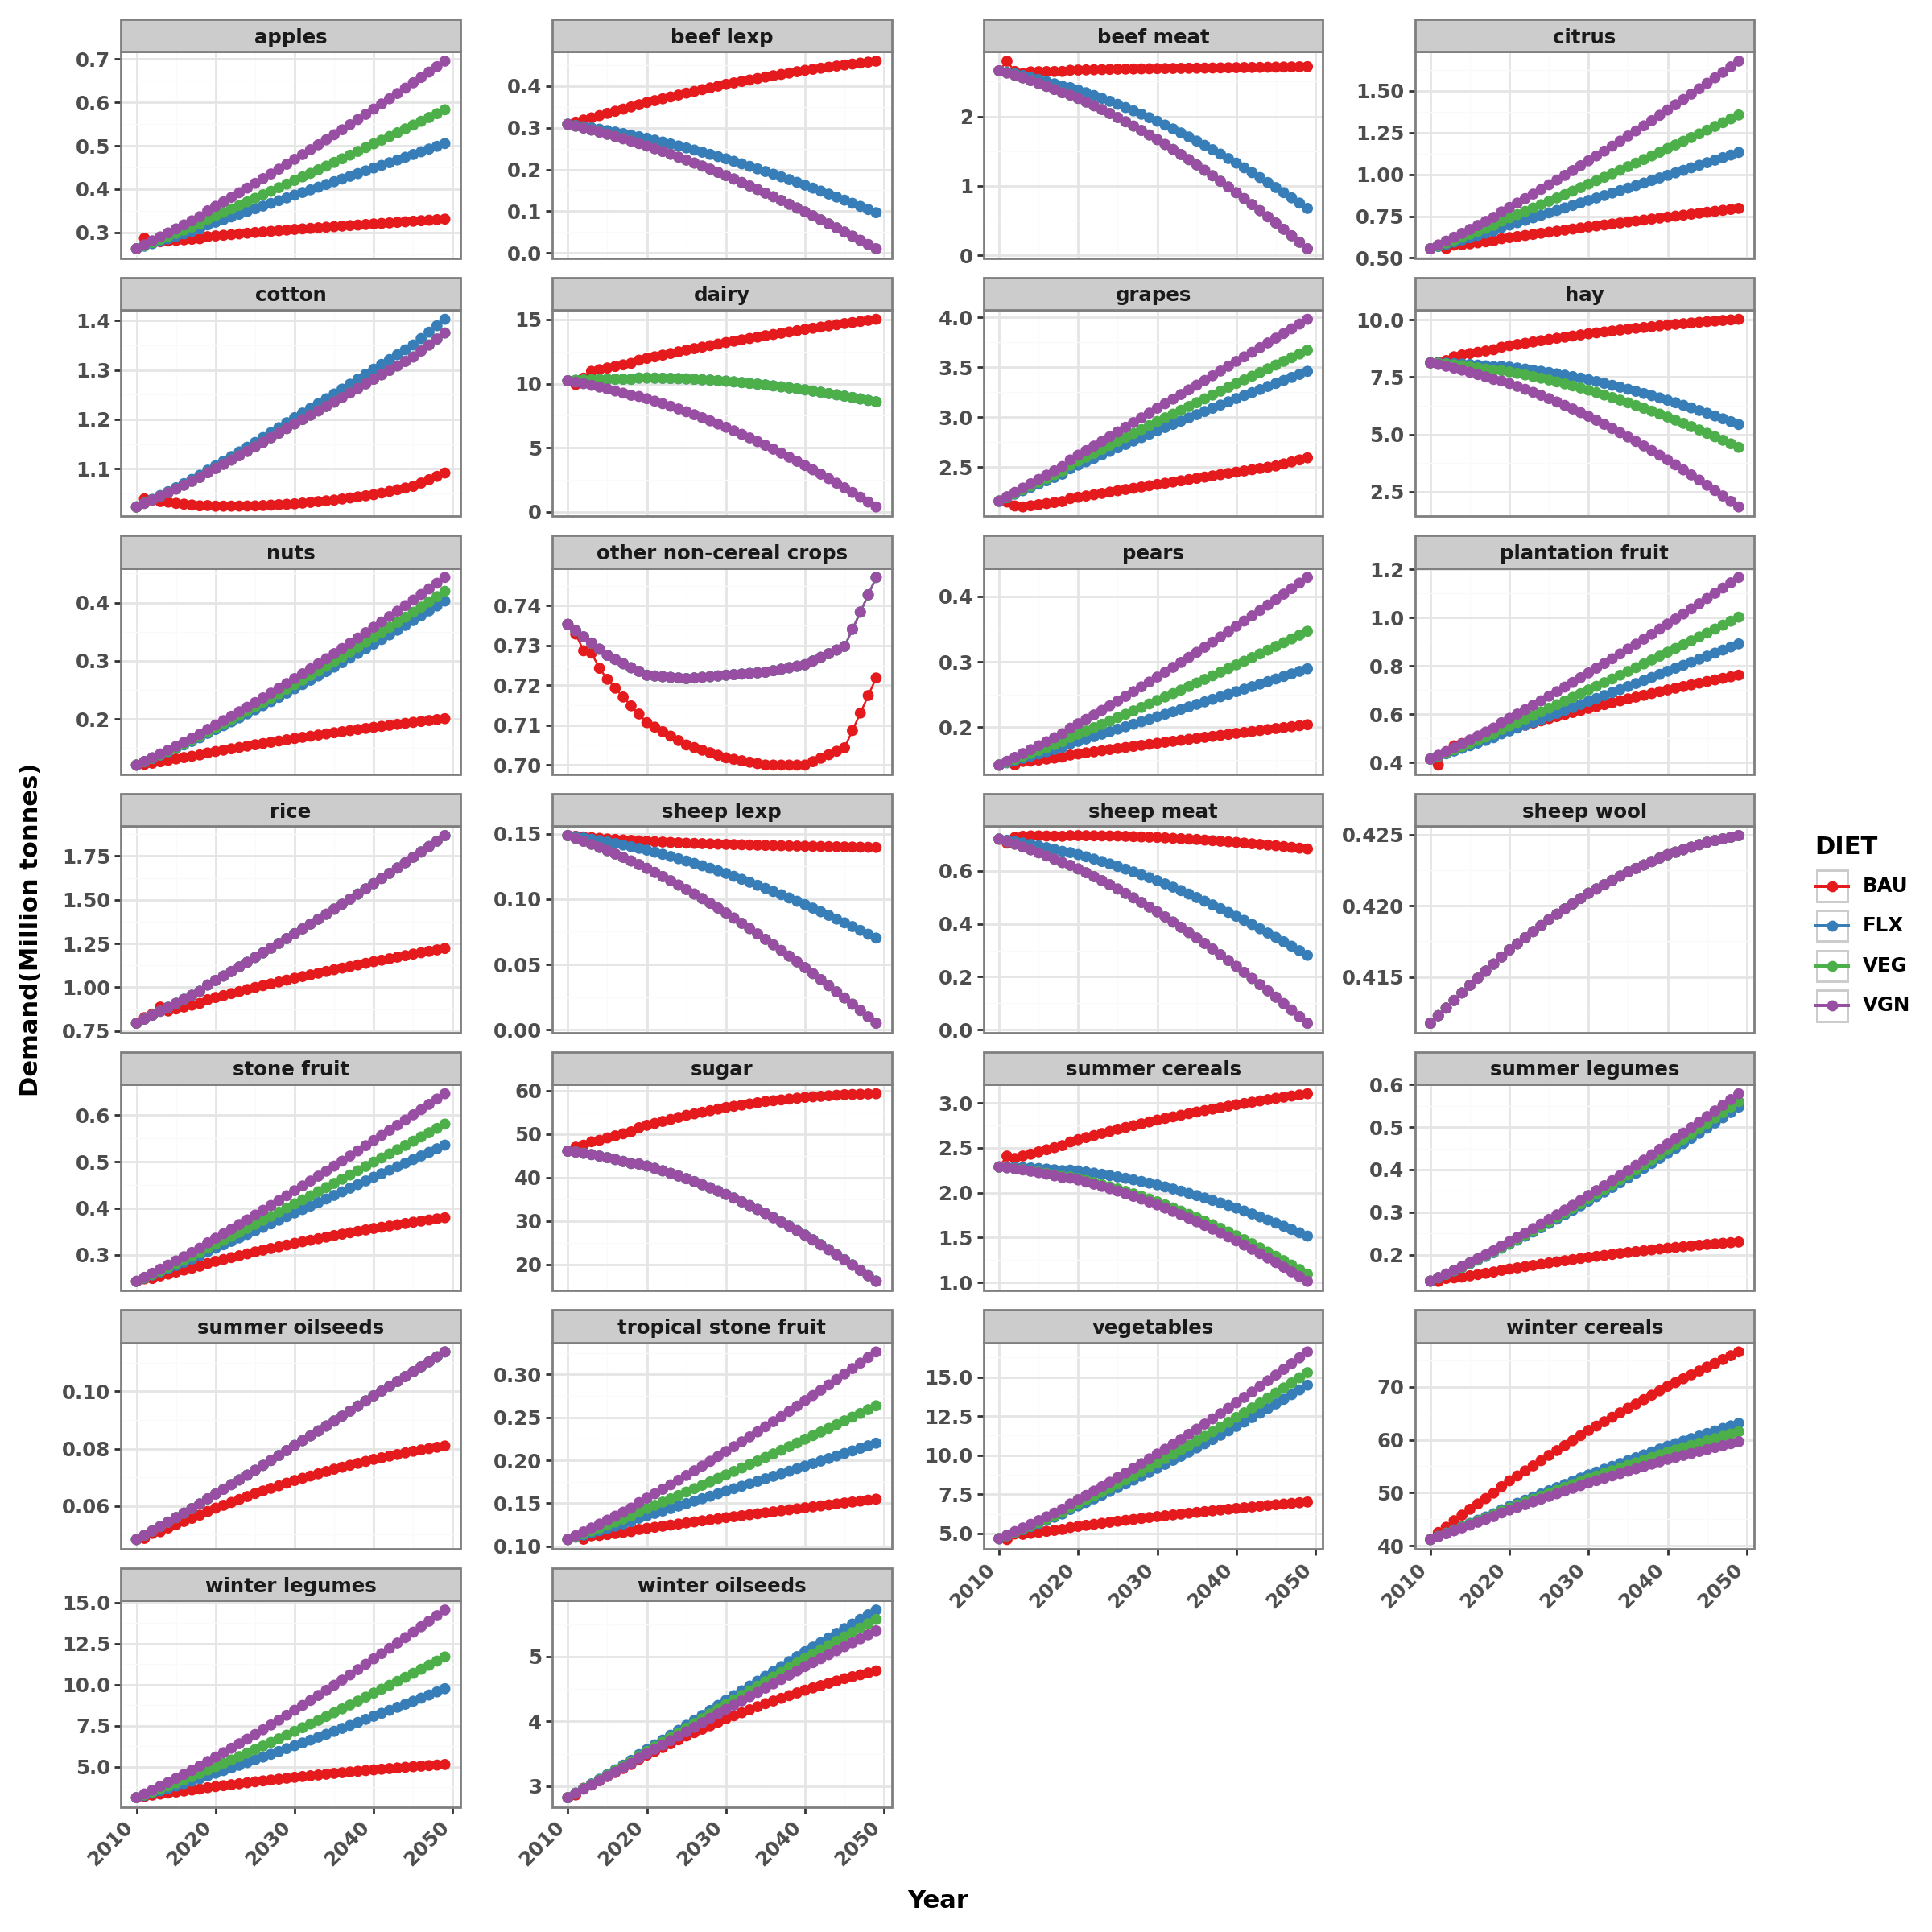

In [2]:
dd = pd.read_hdf(os.path.join(settings.INPUT_DIR, 'demand_projections.h5'))
DIETs = ['BAU', 'FLX', 'VEG', 'VGN']

# 1. Initialize an empty list to store the results from each loop
all_diets_data = []

for d in DIETs:
    # This part of your code remains the same
    DEMAND_DATA = dd.loc[(settings.SCENARIO,
                          d,
                          d,
                          settings.CONVERGENCE,
                          settings.IMPORT_TREND,
                          settings.WASTE,
                          settings.FEED_EFFICIENCY)].copy()
    DEMAND_DATA.loc['eggs'] = DEMAND_DATA.loc['eggs'] * settings.EGGS_AVG_WEIGHT / 1000 / 1000

    # Remove off-land commodities (this also remains the same)
    DEMAND_C = DEMAND_DATA.loc[DEMAND_DATA.query("COMMODITY not in @settings.OFF_LAND_COMMODITIES").index, 'PRODUCTION'].copy()

    # --- Start of new logic ---
    # 2. Convert the Series to a DataFrame and reset the index
    # This turns the 'COMMODITY' from the index into a column
    long_format_df = DEMAND_C.reset_index()

    # 3. Add a new column to identify the diet scenario
    long_format_df['DIET'] = d

    # 4. Append the DataFrame for the current diet to our list
    all_diets_data.append(long_format_df)
    # --- End of new logic ---

# 5. Concatenate all the DataFrames in the list into a single long table
final_long_table = pd.concat(all_diets_data, ignore_index=True)

df = final_long_table.melt(
    id_vars=['COMMODITY','DIET'],      # 保持不变的列
    var_name='YEAR',            # 新的列，用于存放年份
    value_name='Demand'     # 新的列，用于存放产量值
)
df["YEAR"] = df["YEAR"].astype(int)
df = df[df["YEAR"] < 2050]
df['Demand' ] = df['Demand' ] / 1e6  # 转换为百万吨

from plotnine import (
    ggplot, aes, geom_line, geom_point, facet_wrap,
    theme_bw, labs, theme, element_text, scale_color_brewer
)


# 按 COMMODITY, DIET, YEAR 汇总（如果已有唯一值可跳过）
agg = (
    df
    .groupby(["COMMODITY", "DIET", "YEAR"], as_index=False)
    .agg({'Demand' : "sum"})
)

# 绘图：每个作物一张子图，每张图有 4 条（对应不同 DIET），子图 y 轴独立（scales='free_y'）
p = (
    ggplot(agg, aes(x="YEAR", y='Demand', color="DIET", group="DIET"))
    + geom_line()
    + geom_point(size=1.8)
    + facet_wrap("~COMMODITY", scales="free_y", ncol=4)  # ncol 可调整列数
    + scale_color_brewer(type="qual", palette="Set1")
    + theme_bw()
    + labs(
        x="Year",
        y='Demand(Million tonnes)' ,
        color="DIET"
    )
    + theme(
        axis_text_x=element_text(rotation=45, hjust=1),
        figure_size=(12, 12)  # 指定输出图片的默认大小（英寸）
    )
)

print(p)

F:\xinhao\miniforge\envs\luto\Lib\site-packages\plotnine\scales\scales.py:48: PlotnineWarning: Scale for 'color' is already present.
Adding another scale for 'color',
which will replace the existing scale.

C:\Users\s222552331\AppData\Local\Temp\35\ipykernel_231080\3500181056.py:94: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


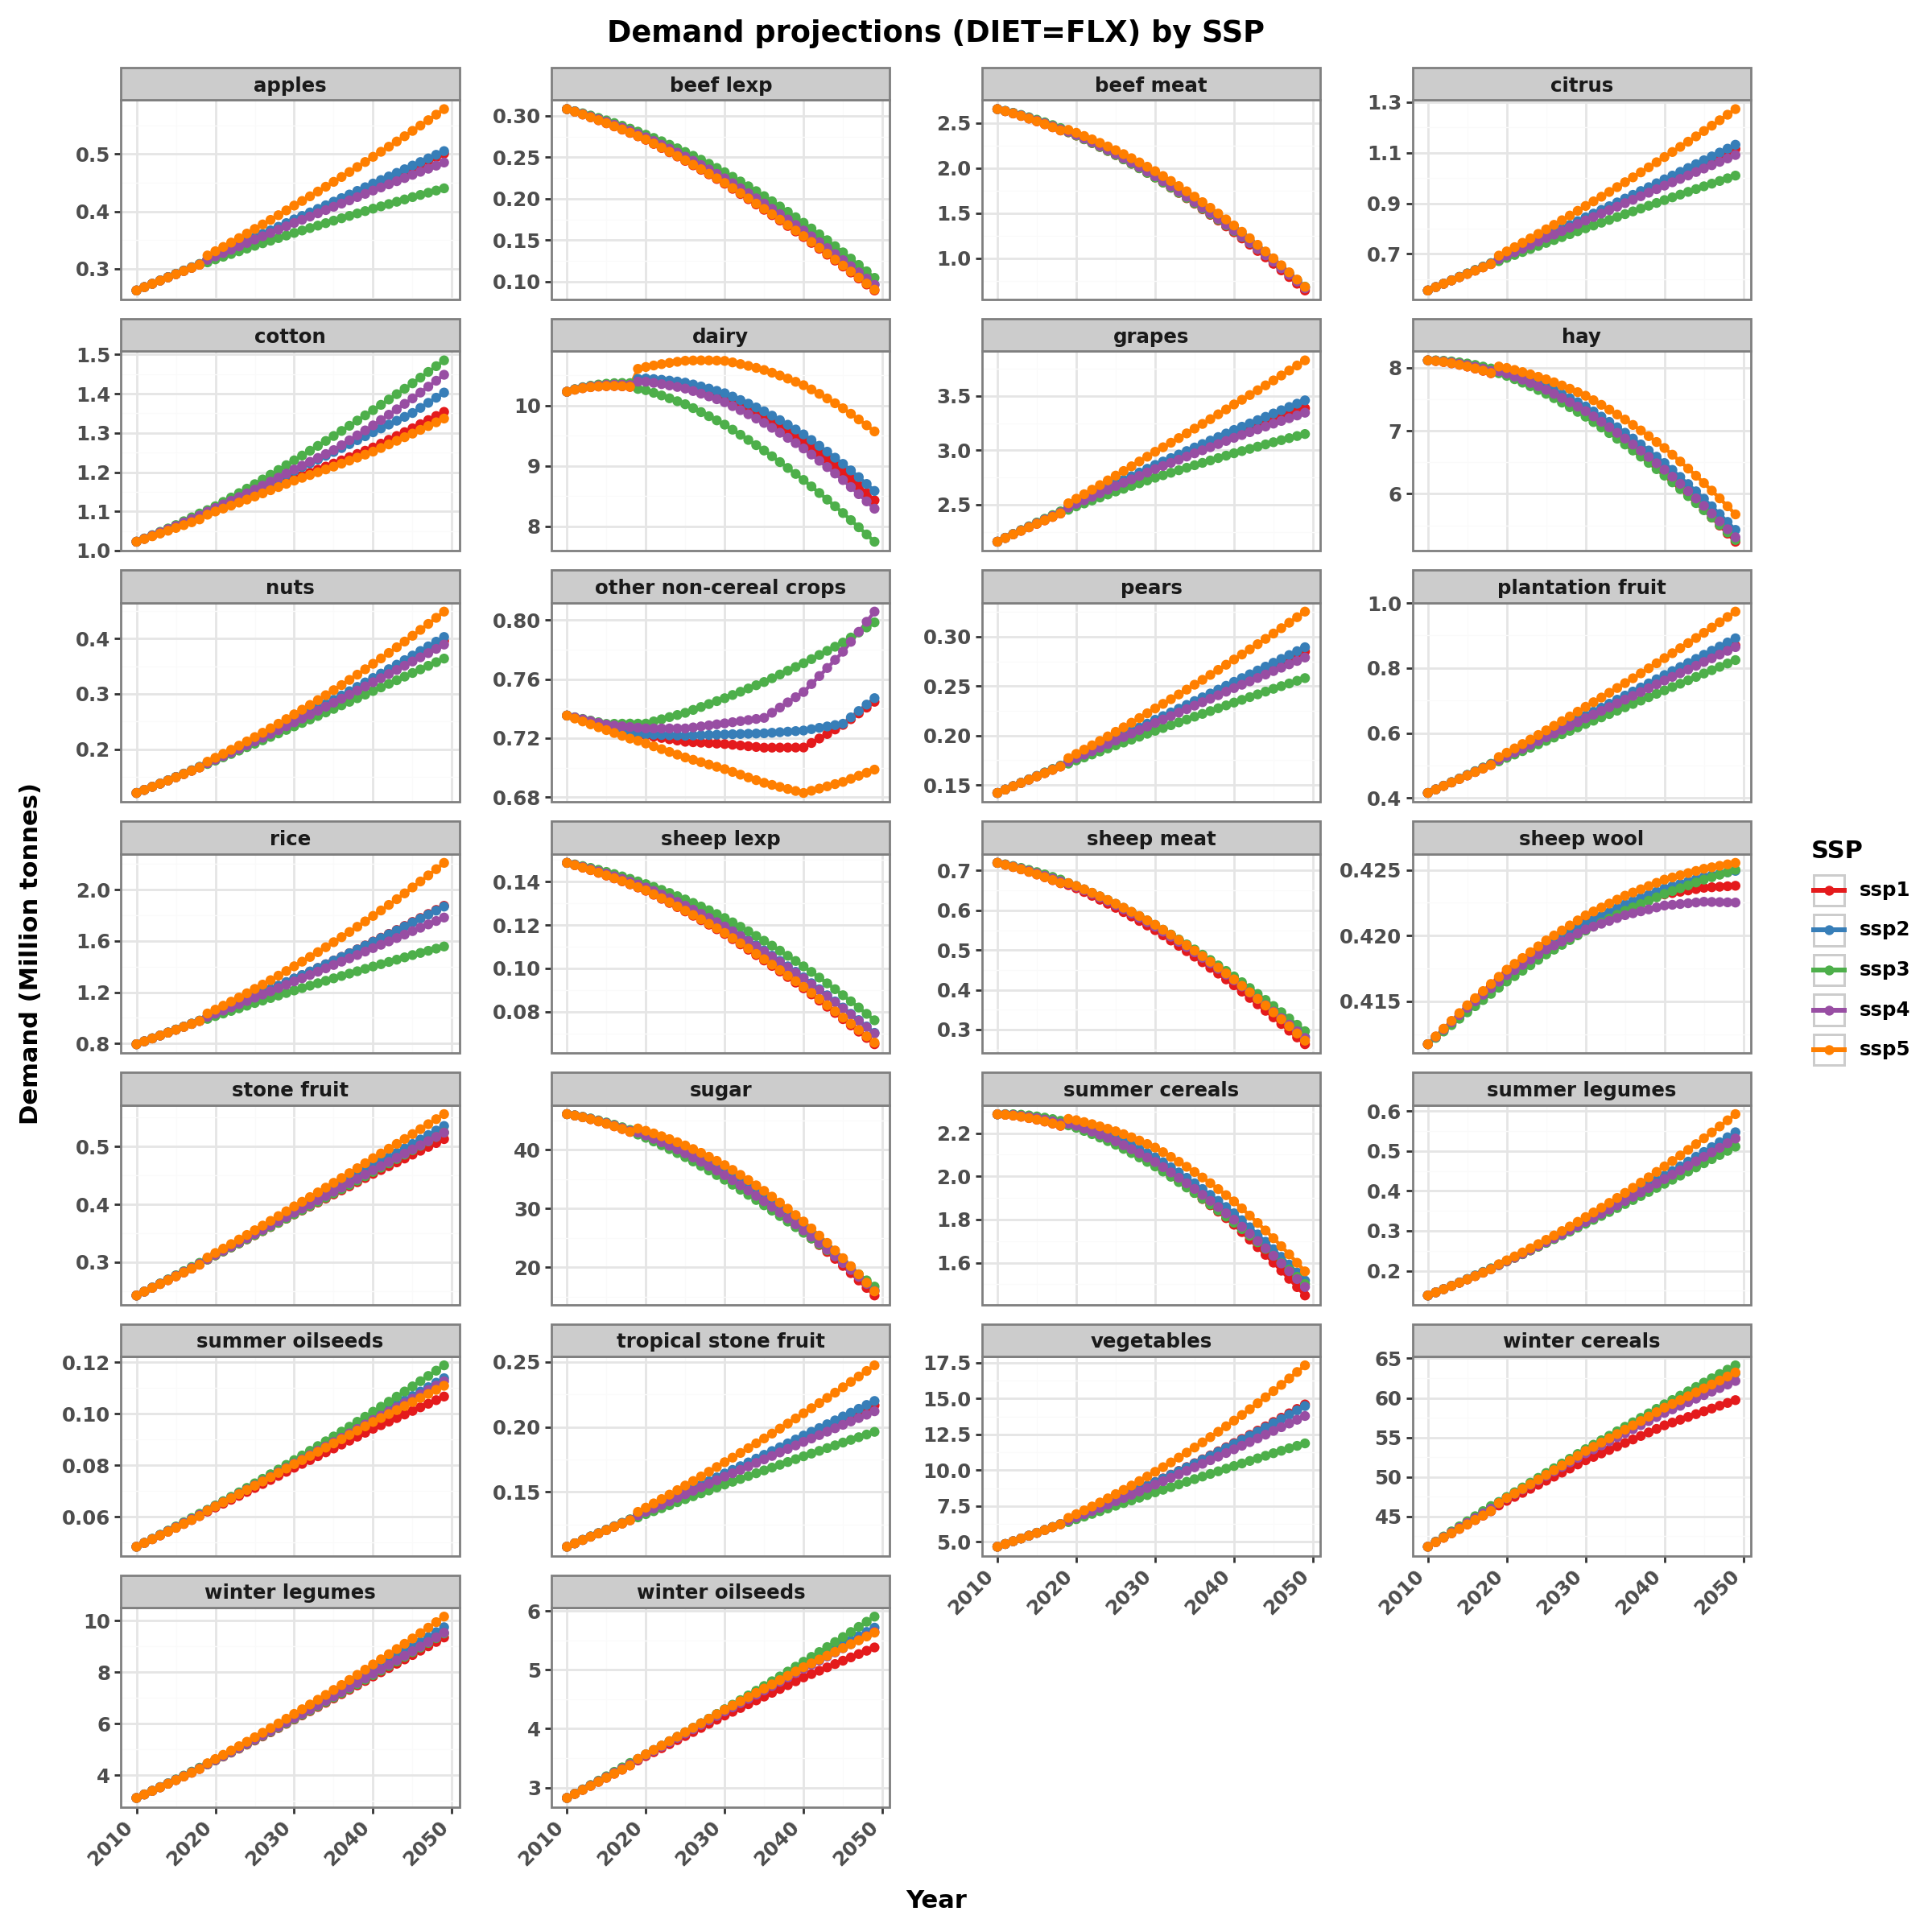

In [3]:
dd = pd.read_hdf(os.path.join(settings.INPUT_DIR, 'demand_projections.h5'))

# 目标：按照 SSP 分类（ssp1 - ssp5），只取 DIET = FLX 情景，合并成长表并绘图
SSP_LIST = ['ssp1', 'ssp2', 'ssp3', 'ssp4', 'ssp5']
DIET_TO_PLOT = 'FLX'

all_ssp_data = []

for s in SSP_LIST:
    # 注意：你的 dd 索引/层级可能使用大写 'SSP1'，如出错请改为 s.upper()
    scenario_key = s.upper()  # 如果你的数据使用小写，请改为 scenario_key = s

    DEMAND_DATA = dd.loc[
        (scenario_key,
         DIET_TO_PLOT,
         DIET_TO_PLOT,
         settings.CONVERGENCE,
         settings.IMPORT_TREND,
         settings.WASTE,
         settings.FEED_EFFICIENCY)
    ].copy()

    # 将 eggs 单位换算为吨（与原代码相同）
    if 'eggs' in DEMAND_DATA.index:
        DEMAND_DATA.loc['eggs'] = DEMAND_DATA.loc['eggs'] * settings.EGGS_AVG_WEIGHT / 1000 / 1000

    # 去掉 off-land commodities
    valid_index = DEMAND_DATA.query("COMMODITY not in @settings.OFF_LAND_COMMODITIES").index
    DEMAND_C = DEMAND_DATA.loc[valid_index, 'PRODUCTION'].copy()

    # 转换为 DataFrame 并重置索引（把 COMMODITY 和 YEAR 等变成列）
    long_format_df = DEMAND_C.reset_index()

    # 添加 SSP 标识列
    long_format_df['SSP'] = s  # 使用原始小写标签便于展示（ssp1..ssp5）

    all_ssp_data.append(long_format_df)

# 合并所有 SSP 的数据
if not all_ssp_data:
    raise RuntimeError("未读取到任何 SSP 数据，请检查 dd 索引和 SSP 列表（或大小写）")

final_long_table = pd.concat(all_ssp_data, ignore_index=True)

# 将宽格式的年份列展开为 YEAR / Demand（melt）
df = final_long_table.melt(
    id_vars=['COMMODITY', 'SSP'],   # 保持不变的列
    var_name='YEAR',
    value_name='Demand'
)

# 清理与类型转换
df["YEAR"] = df["YEAR"].astype(int)
df = df[df["YEAR"] < 2050]       # 只画 2050 年之前的
df['Demand'] = df['Demand'] / 1e6  # 转换为百万吨

# 按 COMMODITY, SSP, YEAR 汇总（若数据已经唯一，这步不会改变值）
agg = (
    df
    .groupby(["COMMODITY", "SSP", "YEAR"], as_index=False)
    .agg({'Demand': "sum"})
)

# 指定 SSP 的显示顺序（保持 ssp1..ssp5）
agg['SSP'] = pd.Categorical(agg['SSP'], categories=SSP_LIST, ordered=True)
SSP_COLORS = {
    'ssp1': '#1b9e77',  # 绿
    'ssp2': '#d95f02',  # 橙
    'ssp3': '#7570b3',  # 紫
    'ssp4': '#e7298a',  # 粉/品红
    'ssp5': '#66a61e',  # 深绿（与 ssp1 有区别）
}
# 绘图：每个作物一张子图（facet），每条线对应一个 SSP（颜色区分），子图 y 轴独立
p = (
    ggplot(agg, aes(x='YEAR', y='Demand', color='SSP', group='SSP'))
    + geom_line(size=0.9)        # 稍微细一点的线
    + geom_point(size=1.5)       # 小一点的点
    + facet_wrap('~COMMODITY', scales='free_y', ncol=4)
    + scale_color_manual(values=SSP_COLORS) 
    + scale_color_brewer(type='qual', palette='Set1')
    + theme_bw()
    + labs(
        x='Year',
        y='Demand (Million tonnes)',
        color='SSP',
        title=f'Demand projections (DIET={DIET_TO_PLOT}) by SSP'
    )
    + theme(
        axis_text_x=element_text(rotation=45, hjust=1),
        figure_size=(12, 12)
    )
)

print(p)

C:\Users\s222552331\AppData\Local\Temp\35\ipykernel_231080\3693302677.py:59: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
C:\Users\s222552331\AppData\Local\Temp\35\ipykernel_231080\3693302677.py:59: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
C:\Users\s222552331\AppData\Local\Temp\35\ipykernel_231080\3693302677.py:59: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
C:\Users\s222552331\AppData\Local\Temp\35\ipykernel_231080\3693302677.py:59: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
C:\Users\s222552331\AppData\Local\Temp\35\ipykernel_231080\3693302677.py:124: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


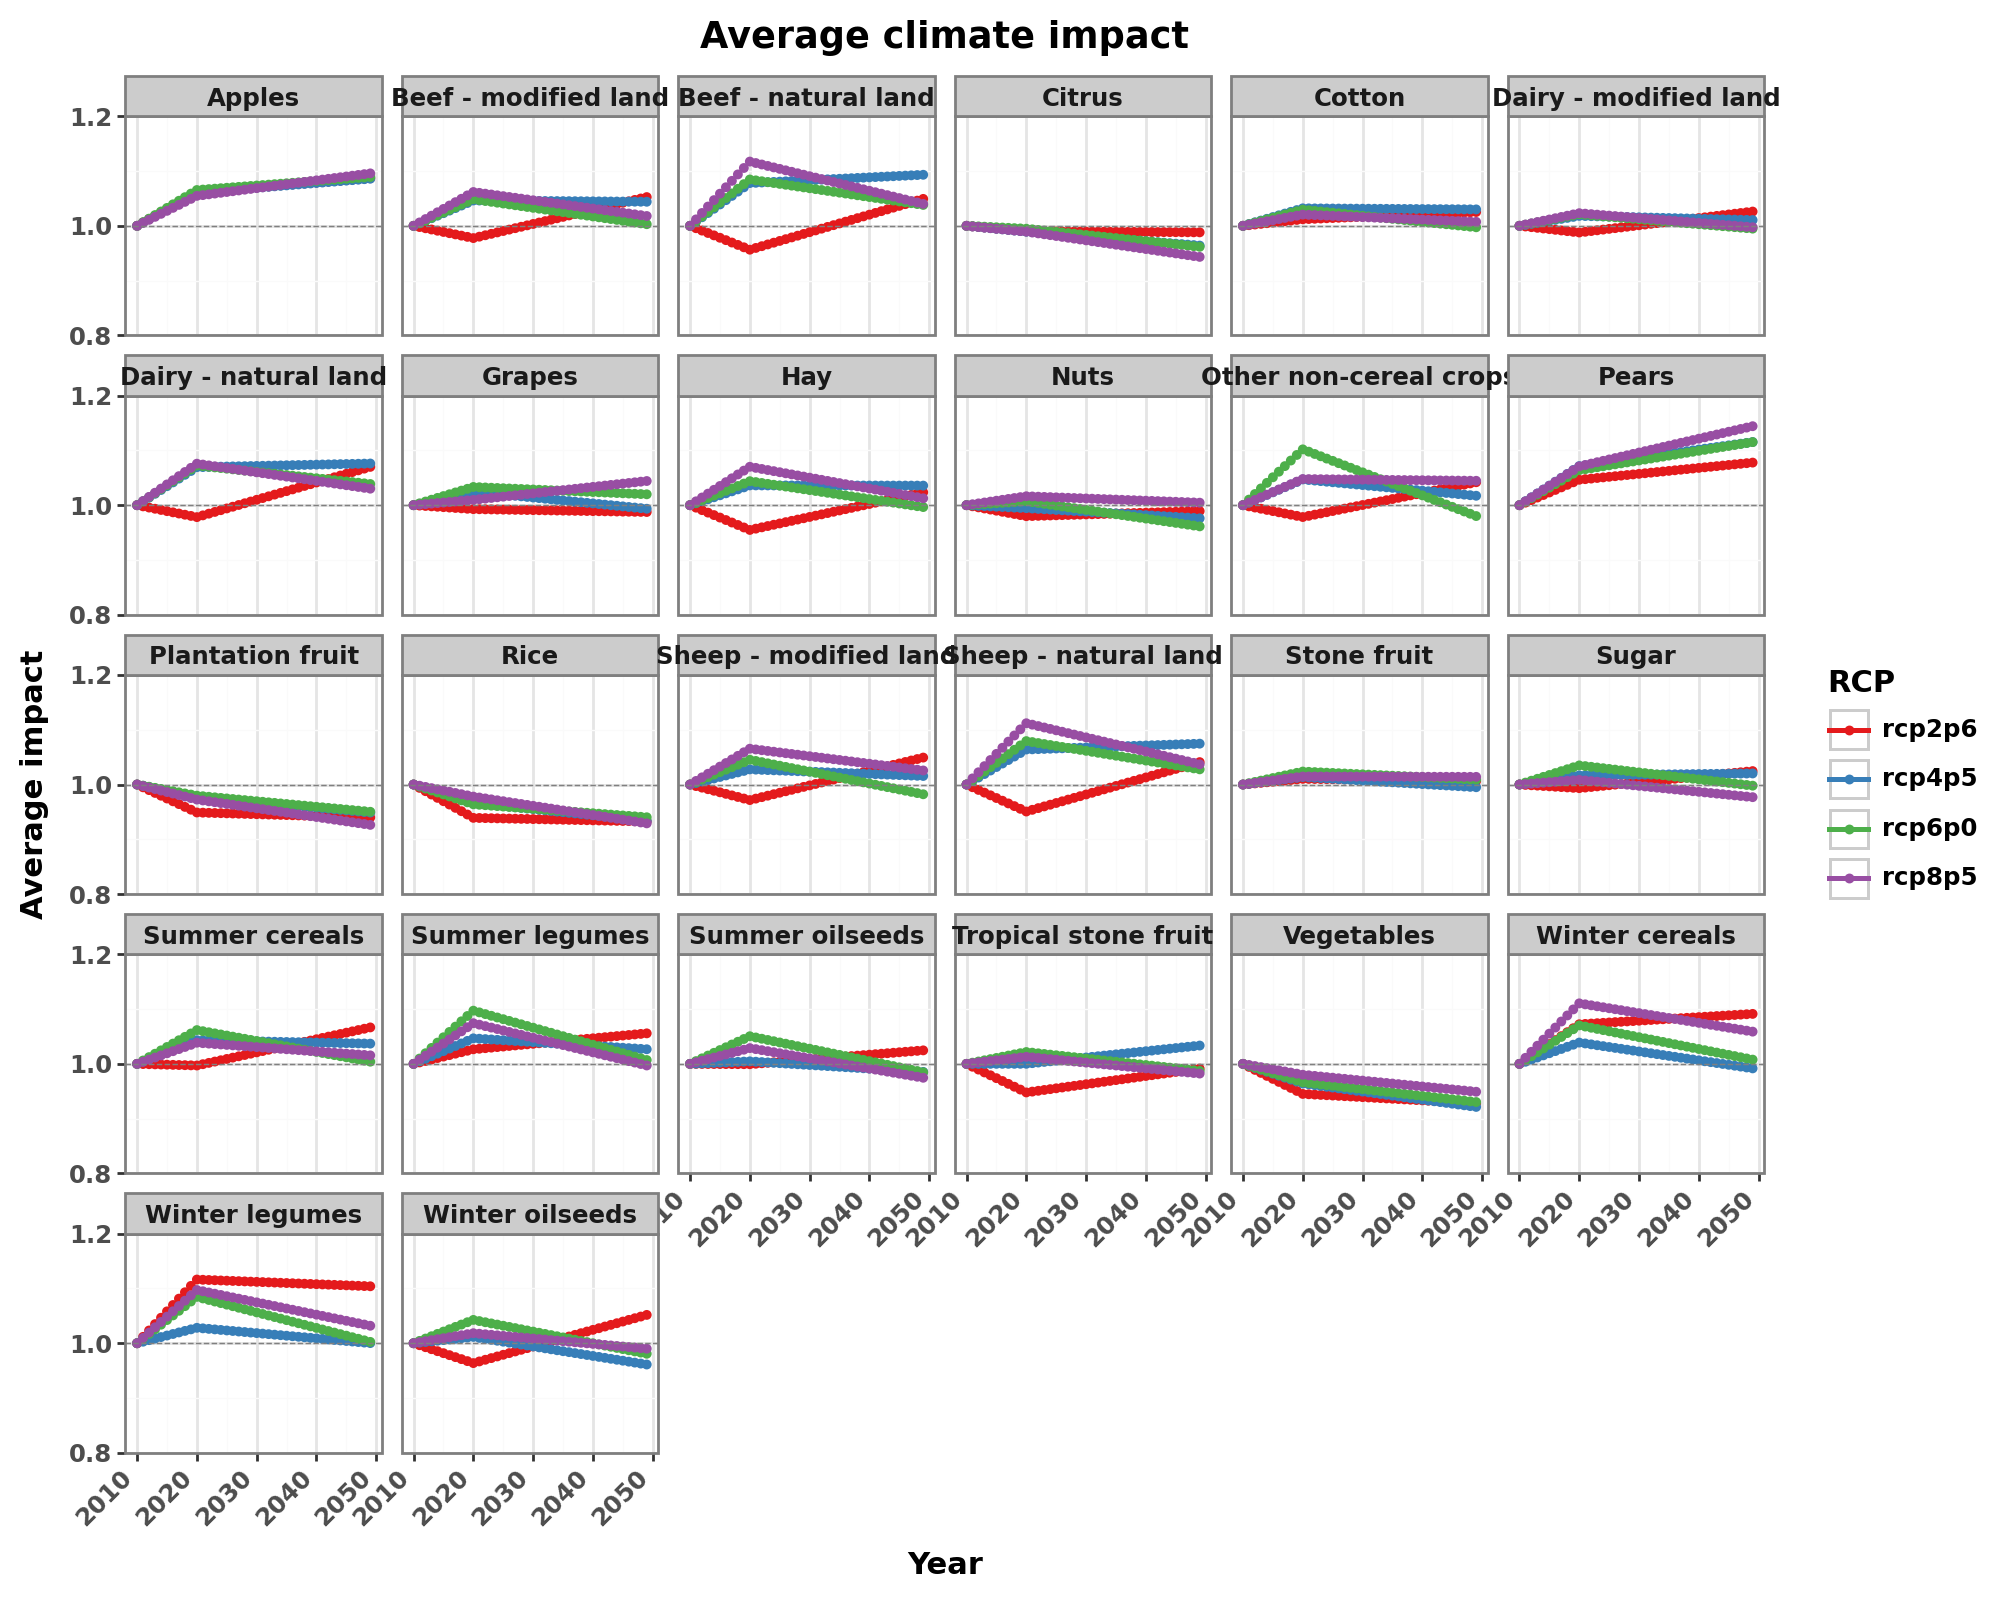

In [4]:
# Set resfactor multiplier
RESMULT = settings.RESFACTOR ** 2

# Set the nodata and non-ag code
NODATA = -9999
MASK_LU_CODE = -1

# Load LUMAP without resfactor
LUMAP_NO_RESFACTOR = pd.read_hdf(os.path.join(settings.INPUT_DIR, "lumap.h5")).to_numpy().astype(np.int8)   # 1D (ij flattend),  0-27 for land uses; -1 for non-agricultural land uses; All cells in Australia (land only)

# NLUM mask.
with rasterio.open(os.path.join(settings.INPUT_DIR, "NLUM_2010-11_mask.tif")) as rst:
    NLUM_MASK = rst.read(1).astype(np.int8)                                                                # 2D map,  0 for ocean, 1 for land
    LUMAP_2D_FULLRES = np.full_like(NLUM_MASK, NODATA, dtype=np.int16)                           # 2D map,  full of nodata (-9999)
    np.place(LUMAP_2D_FULLRES, NLUM_MASK == 1, LUMAP_NO_RESFACTOR)                               # 2D map,  -9999 for ocean; -1 for desert, urban, water, etc; 0-27 for land uses
    GEO_META_FULLRES = rst.meta                                                                            # dict,  key-value pairs of geospatial metadata for the full resolution land-use map
    GEO_META_FULLRES['dtype'] = 'float32'                                                                  # Set the data type to float32
    GEO_META_FULLRES['nodata'] = NODATA                                                               # Set the nodata value to -9999

# Mask out non-agricultural, non-environmental plantings land (i.e., -1) from lumap 
# (True means included cells. Boolean dtype.)
LUMASK = LUMAP_NO_RESFACTOR != MASK_LU_CODE                                                      # 1D (ij flattend);  `True` for land uses; `False` for desert, urban, water, etc

# Return combined land-use and resfactor mask
if settings.RESFACTOR > 1:
    rf_mask = NLUM_MASK.copy()
    nonzeroes = np.nonzero(rf_mask)
    rf_mask[int(settings.RESFACTOR/2)::settings.RESFACTOR, int(settings.RESFACTOR/2)::settings.RESFACTOR] = 0
    resmask = np.where(rf_mask[nonzeroes] == 0, True, False)
    MASK = LUMASK * resmask
    LUMAP_2D_RESFACTORED = LUMAP_2D_FULLRES[int(settings.RESFACTOR/2)::settings.RESFACTOR, int(settings.RESFACTOR/2)::settings.RESFACTOR]
    GEO_META = update_geo_meta()
elif settings.RESFACTOR == 1:
    MASK = LUMASK
    GEO_META = GEO_META_FULLRES
    LUMAP_2D_RESFACTORED = LUMAP_2D_FULLRES
else:
    raise KeyError("Resfactor setting invalid")


RCP_LIST = ["rcp2p6", "rcp4p5", "rcp6p0", "rcp8p5"]
YR_CAL_BASE = 2010

results_list = []

for rcp in RCP_LIST:
    h5name = f"climate_change_impacts_{rcp}_CO2_FERT_{settings.CO2_FERT.upper()}.h5"
    h5path = os.path.join(settings.INPUT_DIR, h5name)

    # 读取数据（若需要筛选则使用 where=MASK）
    if MASK is not None:
        CLIMATE_CHANGE_IMPACT = pd.read_hdf(h5path, where=MASK)
    else:
        CLIMATE_CHANGE_IMPACT = pd.read_hdf(h5path)

    CLIMATE_CHANGE_IMPACT.columns.names = ['management', 'land_use', 'year']

    # 按 land_use 和 year 聚合（对列级别聚合，再对行取平均）
    aggregated_series = CLIMATE_CHANGE_IMPACT.groupby(axis=1, level=['land_use', 'year']).mean().mean(axis=0)
    avg_impact_wide = aggregated_series.unstack(level='land_use')

    # 尝试把年份 index 转为整数
    try:
        years_index = list(map(int, avg_impact_wide.index.tolist()))
        avg_impact_wide.index = years_index
    except Exception:
        pass

    start_year = YR_CAL_BASE
    end_year = int(avg_impact_wide.index.max())
    years_to_interpolate = np.arange(start_year, end_year + 1)

    for land_use in avg_impact_wide.columns:
        # 已知点：2010 -> 1.0，后面是原始年份点
        x_known = [YR_CAL_BASE] + list(avg_impact_wide.index)
        y_known = [1.0] + list(avg_impact_wide[land_use].values)

        f = interp1d(x_known, y_known, kind='linear', fill_value='extrapolate', bounds_error=False)
        interpolated_impacts = f(years_to_interpolate)

        for i, year in enumerate(years_to_interpolate):
            results_list.append({
                'rcp': rcp,
                'land_use': land_use,
                'year': int(year),
                'average_impact': float(interpolated_impacts[i])
            })

# 合并为 DataFrame
final_long_df = pd.DataFrame(results_list)

if final_long_df.empty:
    raise RuntimeError("未生成任何数据：请检查输入文件和 MASK 设置。")

# 只保留 2050 年之前的数据（如果你不想要这个过滤，可以注释下一行）
final_long_df = final_long_df[final_long_df['year'] < 2050]

# 指定 RCP 顺序
final_long_df['rcp'] = pd.Categorical(final_long_df['rcp'], categories=RCP_LIST, ordered=True)

# 绘图：所有子图使用相同 y 轴范围 [0, 1.2]，并显示 y=1，线较细，点较小
p = (
    ggplot(final_long_df, aes(x='year', y='average_impact', color='rcp', group='rcp'))
    + geom_line(size=0.7)        # 线细一些
    + geom_point(size=1.0)       # 点小一些
    + geom_hline(yintercept=1.0, linetype='dashed', color='gray', size=0.3)  # 确保 y=1 可见
    + facet_wrap('~land_use', scales='fixed', ncol=6)  # 相同 y 轴（scales='fixed'）
    + scale_color_brewer(type='qual', palette='Set1')
    + scale_y_continuous(limits=(0.8, 1.2), breaks=[0.8, 1.0, 1.2], expand=(0, 0))
    + theme_bw()
    + labs(
        title='Average climate impact',
        x='Year',
        y='Average impact',
        color='RCP'
    )
    + theme(
        axis_text_x=element_text(rotation=45, hjust=1),
        figure_size=(10, 8)
    )
)

# 在交互式环境下直接显示（可选）
print(p)

2010-2024年期间的分析:
年均增长率 (Mean): 3.79%
增长率标准差 (Std Dev): 2.66%

基于数据波动性定义的四种未来增长情景:
低增长情景 (Mean - 0.5*Std): 3.53%
中等增长情景 (Mean): 3.79%
高增长情景 (Mean + 0.5*Std): 4.06%
非常高增长情景 (Mean + 1.0*Std): 4.32%


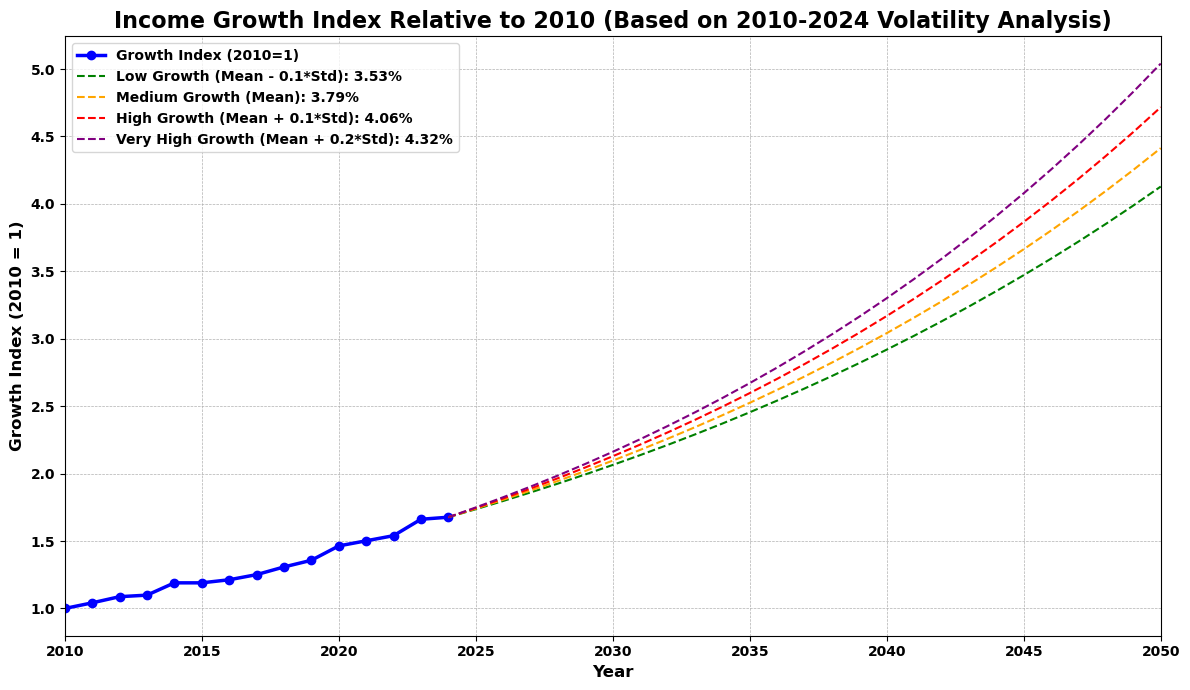

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. 原始数据
years_str = [
    'Aug-97', 'Aug-98', 'Aug-99', 'Aug-00', 'Aug-01', 'Aug-02', 'Aug-03', 'Aug-04',
    'Aug-05', 'Aug-06', 'Aug-07', 'Aug-08', 'Aug-09', 'Aug-10', 'Aug-11', 'Aug-12',
    'Aug-13', 'Aug-14', 'Aug-15', 'Aug-16', 'Aug-17', 'Aug-18', 'Aug-19', 'Aug-20',
    'Aug-21', 'Aug-22', 'Aug-23', 'Aug-24'
]
hourly_income = [
    15.2, 15.8, 16.4, 17.1, 17.8, 18.7, 19.2, 20.0, 21.0, 21.8, 22.9, 24.3,
    25.0, 26.3, 27.4, 28.6, 28.9, 31.3, 31.3, 31.9, 32.9, 34.4, 35.7, 38.5,
    39.5, 40.5, 43.7, 44.1
]

# 2. 数据处理
years = [int(s.split('-')[1]) + (1900 if int(s.split('-')[1]) > 90 else 2000) for s in years_str]
df = pd.DataFrame({'Year': years, 'Hourly_Income': hourly_income})

# 3. 筛选2010-2024年的数据
df_period = df[df['Year'] >= 2010].copy()

# 4. 计算相对于2010年的“增长指数”
base_income_2010 = df_period[df_period['Year'] == 2010]['Hourly_Income'].iloc[0]
df_period['Growth_Index'] = df_period['Hourly_Income'] / base_income_2010

# 5. 基于2010-2024数据，进行统计分析以定义未来情景
# 计算2011-2024年间，每年的同比增长率
df_period['YoY_Growth'] = df_period['Hourly_Income'].pct_change()
# 计算这些年增长率的平均值和标准差
mean_growth = df_period['YoY_Growth'].mean()
std_dev_growth = df_period['YoY_Growth'].std()

print(f"2010-2024年期间的分析:")
print(f"年均增长率 (Mean): {mean_growth*100:.2f}%")
print(f"增长率标准差 (Std Dev): {std_dev_growth*100:.2f}%")

# 6. 使用统计结果构建四种未来增长情景 (更严谨的方法)
medium_growth = mean_growth
low_growth = mean_growth - 0.1 * std_dev_growth
high_growth = mean_growth + 0.1 * std_dev_growth
very_high_growth = mean_growth + 0.2 * std_dev_growth

print("\n基于数据波动性定义的四种未来增长情景:")
print(f"低增长情景 (Mean - 0.5*Std): {low_growth*100:.2f}%")
print(f"中等增长情景 (Mean): {medium_growth*100:.2f}%")
print(f"高增长情景 (Mean + 0.5*Std): {high_growth*100:.2f}%")
print(f"非常高增长情景 (Mean + 1.0*Std): {very_high_growth*100:.2f}%")


# 7. 准备未来预测
last_year = df_period['Year'].iloc[-1]
last_index = df_period['Growth_Index'].iloc[-1]
future_years = np.arange(last_year, 2051)

# 定义一个函数，用于从最后一个已知点开始，按给定的年增长率进行复利计算
def project_future_index(start_index, years_array, start_year, growth_rate):
    t = years_array - start_year
    return start_index * ((1 + growth_rate) ** t)

# 为四种情景分别计算预测的增长指数
low_pred = project_future_index(last_index, future_years, last_year, low_growth)
medium_pred = project_future_index(last_index, future_years, last_year, medium_growth)
high_pred = project_future_index(last_index, future_years, last_year, high_growth)
very_high_pred = project_future_index(last_index, future_years, last_year, very_high_growth)


# 8. 绘图
# 8. Plotting
plt.figure(figsize=(12, 7))

# Plot the historical growth index (solid line)
plt.plot(df_period['Year'], df_period['Growth_Index'], label='Growth Index (2010=1)', color='blue', linewidth=2.5, marker='o')

# Plot the four future scenarios (dashed lines)
plt.plot(future_years, low_pred, label=f'Low Growth (Mean - 0.1*Std): {low_growth*100:.2f}%', linestyle='--', color='green')
plt.plot(future_years, medium_pred, label=f'Medium Growth (Mean): {medium_growth*100:.2f}%', linestyle='--', color='orange')
plt.plot(future_years, high_pred, label=f'High Growth (Mean + 0.1*Std): {high_growth*100:.2f}%', linestyle='--', color='red')
plt.plot(future_years, very_high_pred, label=f'Very High Growth (Mean + 0.2*Std): {very_high_growth*100:.2f}%', linestyle='--', color='purple')


# 9. Set chart styles
plt.title('Income Growth Index Relative to 2010 (Based on 2010-2024 Volatility Analysis)', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Growth Index (2010 = 1)', fontsize=12)
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xlim(2010, 2050)
plt.tight_layout()

# 10. Save and show the plot
plt.savefig('FLC_growth_index.png')
plt.show()

2010-2024年期间的分析:
年均增长率 (Mean): 0.51%
增长率标准差 (Std Dev): 3.43%

基于数据波动性定义的四种未来增长情景:
低增长情景 (Mean - 0.5*Std): 0.17%
中等增长情景 (Mean): 0.51%
高增长情景 (Mean + 0.5*Std): 0.85%
非常高增长情景 (Mean + 1.0*Std): 1.20%


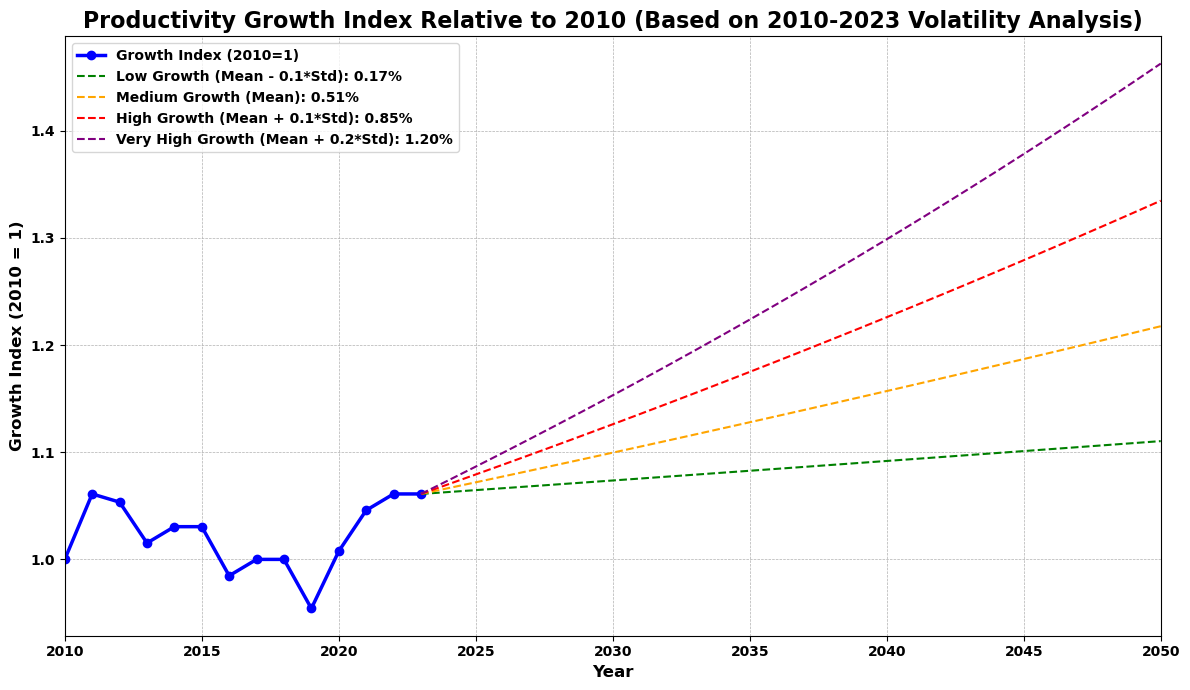

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

base_year = 2010
# 1. 原始数据
financial_year = ["1988-89", "1989-90", "1990-91", "1991-92", "1992-93", "1993-94", "1994-95", "1995-96", "1996-97", "1997-98", "1998-99", "1999-2000", "2000-01", "2001-02", "2002-03", "2003-04", "2004-05", "2005-06", "2006-07", "2007-08", "2008-09", "2009-10", "2010-11", "2011-12", "2012-13", "2013-14", "2014-15", "2015-16", "2016-17", "2017-18", "2018-19", "2019-20", "2020-21", "2021-22", "2022-23", "2023-24"]

all_australia = [103, 109, 114, 117, 118, 118, 122, 118, 118, 118, 118, 124, 116, 118, 113, 115, 117, 124, 126, 129, 129, 129, 131, 139, 138, 133, 135, 135, 129, 131, 131, 125, 132, 137, 139, 139]

# 2. 数据处理
years = [int(s.split('-')[0]) for s in financial_year]
df = pd.DataFrame({'Year': years, 'Hourly_Income': all_australia})

# 3. 筛选2010-2024年的数据
df_period = df[df['Year'] >= base_year].copy()

# 4. 计算相对于2010年的“增长指数”
base_income_2010 = df_period[df_period['Year'] == base_year]['Hourly_Income'].iloc[0]
df_period['Growth_Index'] = df_period['Hourly_Income'] / base_income_2010

# 5. 基于2010-2024数据，进行统计分析以定义未来情景
# 计算2011-2024年间，每年的同比增长率
df_period['YoY_Growth'] = df_period['Hourly_Income'].pct_change()
# 计算这些年增长率的平均值和标准差
mean_growth = df_period['YoY_Growth'].mean()
std_dev_growth = df_period['YoY_Growth'].std()

print(f"2010-2024年期间的分析:")
print(f"年均增长率 (Mean): {mean_growth*100:.2f}%")
print(f"增长率标准差 (Std Dev): {std_dev_growth*100:.2f}%")

# 6. 使用统计结果构建四种未来增长情景 (更严谨的方法)
medium_growth = mean_growth
low_growth = mean_growth - 0.1 * std_dev_growth
high_growth = mean_growth + 0.1 * std_dev_growth
very_high_growth = mean_growth + 0.2 * std_dev_growth

print("\n基于数据波动性定义的四种未来增长情景:")
print(f"低增长情景 (Mean - 0.5*Std): {low_growth*100:.2f}%")
print(f"中等增长情景 (Mean): {medium_growth*100:.2f}%")
print(f"高增长情景 (Mean + 0.5*Std): {high_growth*100:.2f}%")
print(f"非常高增长情景 (Mean + 1.0*Std): {very_high_growth*100:.2f}%")


# 7. 准备未来预测
last_year = df_period['Year'].iloc[-1]
last_index = df_period['Growth_Index'].iloc[-1]
future_years = np.arange(last_year, 2051)

# 定义一个函数，用于从最后一个已知点开始，按给定的年增长率进行复利计算
def project_future_index(start_index, years_array, start_year, growth_rate):
    t = years_array - start_year
    return start_index * ((1 + growth_rate) ** t)

# 为四种情景分别计算预测的增长指数
low_pred = project_future_index(last_index, future_years, last_year, low_growth)
medium_pred = project_future_index(last_index, future_years, last_year, medium_growth)
high_pred = project_future_index(last_index, future_years, last_year, high_growth)
very_high_pred = project_future_index(last_index, future_years, last_year, very_high_growth)


# 8. 绘图
# 8. Plotting
plt.figure(figsize=(12, 7))

# Plot the historical growth index (solid line)
plt.plot(df_period['Year'], df_period['Growth_Index'], label='Growth Index (2010=1)', color='blue', linewidth=2.5, marker='o')

# Plot the four future scenarios (dashed lines)
plt.plot(future_years, low_pred, label=f'Low Growth (Mean - 0.1*Std): {low_growth*100:.2f}%', linestyle='--', color='green')
plt.plot(future_years, medium_pred, label=f'Medium Growth (Mean): {medium_growth*100:.2f}%', linestyle='--', color='orange')
plt.plot(future_years, high_pred, label=f'High Growth (Mean + 0.1*Std): {high_growth*100:.2f}%', linestyle='--', color='red')
plt.plot(future_years, very_high_pred, label=f'Very High Growth (Mean + 0.2*Std): {very_high_growth*100:.2f}%', linestyle='--', color='purple')


# 9. Set chart styles
plt.title(f'Productivity Growth Index Relative to {base_year} (Based on {base_year}-2023 Volatility Analysis)', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Growth Index (2010 = 1)', fontsize=12)
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xlim(base_year, 2050)
plt.tight_layout()

# 10. Save and show the plot
plt.savefig('productive_growth_index.png')
plt.show()